# **Assignment 5 - Task 3: Universal Sparse Autoencoders**

## **TASK 3.1: USAE TRAINING & SETUP**
This part covers the setup, activation extraction, and training of a Universal Sparse Autoencoder (USAE) to align features between a ResNet-18 and a ViT-B/16.

In [1]:
# # Clear GPU memory
# import gc
# import torch

# # torch.cuda.empty_cache()
# gc.collect()

# # Check available memory
# print(f"GPU Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
# print(f"GPU Memory reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
# print(f"GPU Memory free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")

In [2]:
# import shutil
# disk = shutil.disk_usage('./')
# print(f"Total: {disk.total / 1e9:.2f} GB")
# print(f"Used: {disk.used / 1e9:.2f} GB")
# print(f"Free: {disk.free / 1e9:.2f} GB")

---

### **SECTION 1: Setup & Installation**

In [3]:
import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import r2_score as sklearn_r2
from torch.utils.data import DataLoader

os.environ["TQDM_NOTEBOOK"] = "0"
os.environ["WANDB_MODE"] = "disabled"
from tqdm import tqdm

# Overcomplete/USAE imports
sys.path.append("./UniversalSAE")  # Add UniversalSAE to Python path
from overcomplete.sae import TopKSAE
from overcomplete.sae.losses import top_k_auxiliary_loss
from overcomplete.sae.optimizer import CosineScheduler
from universal_sae.train import train_cross_prediction_saes

# Verify GPU
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )

GPU Available: True
GPU Name: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
GPU Memory: 101.97 GB


In [4]:
# # Delete any old cached files
# import shutil
# if os.path.exists('./cached_activations'):
#     shutil.rmtree('./cached_activations')
# os.makedirs('./cached_activations')

---

### **SECTION 2: Model Selection & Activation Extraction**

We will use two distinct architectures trained on CIFAR concepts:
1. **ResNet-18** (CNN)
2. **ViT-B/16** (Transformer)

In [5]:
# Choose 2 models with different architectures
# ResNet-18: CNN-based
model_resnet = torchvision.models.resnet18(pretrained=True).cuda().eval()

# ViT-B/16: Transformer-based
model_vit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True).cuda().eval()

# Remove classification heads to get features where possible, or just ignore output
model_resnet = nn.Sequential(*list(model_resnet.children())[:-1])  # Remove avgpool + fc
model_vit.head = nn.Identity()  # Remove classification head

/venv/main/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
/venv/main/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/venv/main/lib/python3.12/site-packag

In [6]:
def extract_activation_layer(model, model_type):
    """Get the layer to extract activations from"""
    if model_type == 'resnet':
        # Extract from layer4 (before global avg pool)
        return model[-2]  # layer4
    elif model_type == 'vit':
        # Extract from last transformer block
        return model.blocks[-1]
    
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
resnet_hook = model_resnet[-2].register_forward_hook(get_activation('resnet'))
vit_hook = model_vit.blocks[-1].register_forward_hook(get_activation('vit'))

In [7]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full CIFAR-100 train set (50k images)
cifar100_train = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

# Create dataloader
cifar_loader = DataLoader(cifar100_train, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

In [8]:
cache_path = './cached_activations/cifar100_activations.pt'

if not os.path.exists(cache_path):
    print("Extracting activations from ResNet and ViT...")
    
    resnet_acts = []
    vit_acts = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(cifar_loader, desc="Extracting activations"):
            images = images.cuda()
            
            # Forward pass through both models
            _ = model_resnet(images)
            _ = model_vit(images)
            
            # Get activations
            # ResNet: (batch, 512, 7, 7) -> interpolate to 14x14 -> (batch, 196, 512)
            resnet_act = activations['resnet']  # (batch, 512, 7, 7)
            resnet_act = torch.nn.functional.interpolate(
                resnet_act, size=(14, 14), mode='bilinear', align_corners=False
            )
            resnet_act = resnet_act.flatten(2).permute(0, 2, 1)  # (batch, 196, 512)
            resnet_acts.append(resnet_act.cpu())
            
            # ViT: (batch, 197, 768) -> remove CLS -> (batch, 196, 768)
            vit_act = activations['vit'][:, 1:, :]  # Remove CLS token
            vit_acts.append(vit_act.cpu())
            
            # Labels (one per image)
            labels_list.append(labels)

    # Concatenate all batches
    resnet_activations = torch.cat(resnet_acts, dim=0)  # (50000, 196, 512)
    vit_activations = torch.cat(vit_acts, dim=0)        # (50000, 196, 768)
    all_labels = torch.cat(labels_list, dim=0)

    print(f"ResNet activations shape: {resnet_activations.shape}")
    print(f"ViT activations shape: {vit_activations.shape}")

    # Save
    os.makedirs('./cached_activations', exist_ok=True)
    torch.save({
        'resnet': resnet_activations,
        'vit': vit_activations,
        'labels': all_labels
    }, './cached_activations/cifar100_activations.pt')

    print("✓ Activations cached successfully!")
    
else:
    print(f"✓ Activations already cached at {cache_path}, skipping extraction")

✓ Activations already cached at ./cached_activations/cifar100_activations.pt, skipping extraction


---

### **SECTION 3: Dataset Preparation**

In [9]:
class MultiModelActivationDataset(torch.utils.data.Dataset):
    def __init__(self, activations_dict, labels):
        """
        activations_dict: {'model_name': tensor of activations}
        labels: labels for each sample
        """
        self.activations = activations_dict
        self.labels = labels
        # We truncate to the length of the smallest dataset to ensure alignment if training requires parallel batches,
        # or just use independent sampling. For this implementation, we assume we want equal batch sizes.
        self.length = min(len(acts) for acts in activations_dict.values())
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        # Return dict of activations for each model
        batch = {name: acts[idx] for name, acts in self.activations.items()}
        return batch, self.labels[idx]

# Load cached activations
cached = torch.load('./cached_activations/cifar100_activations.pt')

# Create dataset
activation_dataset = MultiModelActivationDataset(
    activations_dict={
        'ResNet': cached['resnet'],
        'ViT': cached['vit']
    },
    labels=cached['labels']
)

print(f"Dataset size: {len(activation_dataset)} samples")

Dataset size: 50000 samples


In [10]:
# Compute mean/std for each model (for normalization)
model_stats = {}

for model_name, cache_key in [('ResNet', 'resnet'), ('ViT', 'vit')]:
    acts = cached[cache_key]
    model_stats[model_name] = {
        'mean': acts.mean().item(),
        'std': acts.std().item(),
        'input_shape': acts.shape[2]  # 512 for ResNet, 768 for ViT
    }
    print(f"{model_name} - Mean: {model_stats[model_name]['mean']:.4f}, Std: {model_stats[model_name]['std']:.4f}")

ResNet - Mean: 0.7213, Std: 1.3053
ViT - Mean: -0.0203, Std: 4.2417


---

### **SECTION 4: USAE Architecture & Training Config**

In [11]:
CONFIG = {
    # Data
    'batch_size': 64,
    
    # Model architecture
    'nb_components': 16384,
    'top_k': 32,
    
    # Training
    'nb_epochs': 80,
    'lr': 3e-4,
    'final_lr': 1e-6,
    'weight_decay': 1e-5,
    'warmup_epochs': 2.0,
    
    # Other
    'standardize': True,
    'debug': 1,  # Logging level
    'run_name': 'USAE_ResNet_ViT_CIFAR100_16k_80ep'
}

SAE_PARAMS = {
    'encoder_module': 'mlp_bn_1',
    'dictionary_initializer': None,
    'data_initializer': None,
    'dictionary_normalization': 'l2',
    'top_k': CONFIG['top_k']
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"    {k}: {v}")


Configuration:
    batch_size: 64
    nb_components: 16384
    top_k: 32
    nb_epochs: 80
    lr: 0.0003
    final_lr: 1e-06
    weight_decay: 1e-05
    warmup_epochs: 2.0
    standardize: True
    debug: 1
    run_name: USAE_ResNet_ViT_CIFAR100_16k_80ep


In [12]:
model_zoo = {
    'ResNet': {
        'input_shape': 512,
        'num_tokens': 196,
        'model_mean': model_stats['ResNet']['mean'],
        'model_std': model_stats['ResNet']['std'],
    },
    'ViT': {
        'input_shape': 768,
        'num_tokens': 196,
        'model_mean': model_stats['ViT']['mean'],
        'model_std': model_stats['ViT']['std'],
    }
}

print("\nModel Zoo:")
for name, config in model_zoo.items():
    print(f"  {name}: input_shape={config['input_shape']}, mean={config['model_mean']:.4f}")


Model Zoo:
  ResNet: input_shape=512, mean=0.7213
  ViT: input_shape=768, mean=-0.0203


---

### **SECTION 5: USAE Training**

In [13]:
# Create dataloader
dataloader = DataLoader(
    activation_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    pin_memory=True, 
    num_workers=8
)

# Calculate training iterations
total_iters = len(activation_dataset) // CONFIG['batch_size'] * CONFIG['nb_epochs']
warmup_iters = int(len(activation_dataset) // CONFIG['batch_size'] * CONFIG['warmup_epochs'])

print(f"Total iterations: {total_iters}")
print(f"Warmup iterations: {warmup_iters}")

# Initialize SAEs (one per model)
saes = {}
optimizers = {}
schedulers = {}

for model_name in model_zoo:
    print(f"\nInitializing SAE for {model_name}...")
    
    saes[model_name] = TopKSAE(
        input_shape=model_zoo[model_name]['input_shape'],
        n_components=CONFIG['nb_components'],
        device='cuda',
        **SAE_PARAMS
    )
    
    optimizers[model_name] = optim.AdamW(
        saes[model_name].parameters(),
        lr=CONFIG['lr'],
        weight_decay=CONFIG['weight_decay']
    )
    
    schedulers[model_name] = CosineScheduler(
        optimizers[model_name],
        CONFIG['lr'],
        CONFIG['final_lr'],
        total_iters=total_iters,
        warmup_iters=warmup_iters,
        start_warmup_value=1e-6
    )
    
    print(f"  ✓ SAE created with {CONFIG['nb_components']} components")

Total iterations: 62480
Warmup iterations: 1562

Initializing SAE for ResNet...
-----HERE-----
  ✓ SAE created with 16384 components

Initializing SAE for ViT...
-----HERE-----
  ✓ SAE created with 16384 components


In [14]:
# Find latest checkpoint for each model
checkpoint_files = {}
for model_name in model_zoo.keys():
    # First check checkpoints folder
    checkpoint_path = f'./checkpoints/usae_{model_name}_final.pth'
    if os.path.exists(checkpoint_path):
        checkpoint_files[model_name] = checkpoint_path
    else:
        # Fallback to weights folder
        files = glob.glob(f'./weights/USAE_ResNet_ViT_CIFAR100_16k_80ep/{model_name}/uni_{model_name}_checkpoint_*.pth')
        if files:
            # Get the one with highest epoch number
            latest = max(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
            checkpoint_files[model_name] = latest

if len(checkpoint_files) == len(model_zoo):
    print("✓ Found existing checkpoints! Loading trained models...")
    for model_name, path in checkpoint_files.items():
        checkpoint = torch.load(path)
        saes[model_name].load_state_dict(checkpoint['model_state_dict'])
        saes[model_name].eval()
        print(f"  ✓ Loaded {model_name} from {path}")
        if 'epoch' in checkpoint:
            print(f"      (epoch {checkpoint['epoch']})")
else:
    print("No checkpoints found. Starting training...")
    # Use the repo's training function
    logs = train_cross_prediction_saes(
        saes=saes,
        dataloader=dataloader,
        criterion=top_k_auxiliary_loss,
        sae_optimizers=optimizers,
        sae_schedulers=schedulers,
        nb_epochs=CONFIG['nb_epochs'],
        clip_grad=1.0,
        monitoring=CONFIG['debug'],
        device='cuda',
        model_name=CONFIG['run_name'],
        model_zoo=model_zoo,
        divide_norm=False,
        seeded=True
    )
    print("\n✓ Training complete!")

✓ Found existing checkpoints! Loading trained models...
  ✓ Loaded ResNet from ./checkpoints/usae_ResNet_final.pth
  ✓ Loaded ViT from ./checkpoints/usae_ViT_final.pth


---

### **SECTION 6: Save Checkpoints**

In [15]:
os.makedirs('./checkpoints', exist_ok=True)

for model_name, sae in saes.items():
    checkpoint_path = f'./checkpoints/usae_{model_name}_final.pth'
    torch.save({
        'model_state_dict': sae.state_dict(),
        'config': CONFIG,
        'model_config': model_zoo[model_name]
    }, checkpoint_path)
    print(f"✓ Saved {model_name} SAE to {checkpoint_path}")

# Save logs only if they exist (i.e., if we trained)
if 'logs' in locals():
    torch.save(logs, './checkpoints/training_logs.pt')
    print("✓ Saved training logs")
else:
    print("✓ Loaded from existing checkpoints, no new logs to save")

✓ Saved ResNet SAE to ./checkpoints/usae_ResNet_final.pth
✓ Saved ViT SAE to ./checkpoints/usae_ViT_final.pth
✓ Loaded from existing checkpoints, no new logs to save


---

### **SECTION 7: Evaluation & Visualization**

In [16]:
def compute_reconstruction_matrix(saes, dataloader, model_zoo, device='cuda', num_batches=50):
    """
    Compute R² matrix: R²[i,j] = reconstruction quality using encoder_i and decoder_j
    """
    model_names = list(model_zoo.keys())
    M = len(model_names)
    r2_matrix = np.zeros((M, M))
    
    with torch.no_grad():
        for batch_idx, (batch_dict, _) in enumerate(tqdm(dataloader, total=num_batches)):
            if batch_idx >= num_batches:
                break
            
            # Try all encoder-decoder combinations
            for i, encoder_model in enumerate(model_names):
                # Get activations from model i
                A_i = batch_dict[encoder_model].cuda()
                batch_size, num_tokens, dim = A_i.shape
                
                # DO NOT NORMALIZE - training didn't use normalization!
                # Flatten to 2D: (batch*tokens, dim)
                A_i_flat = A_i.reshape(-1, dim)
                
                # Encode with model i's encoder
                _, Z = saes[encoder_model].encode(A_i_flat)
                
                # Decode to all models
                for j, decoder_model in enumerate(model_names):
                    # Decode to model j
                    A_hat_j_flat = saes[decoder_model].decode(Z)
                    
                    # Get ground truth for model j
                    A_j = batch_dict[decoder_model].cuda()
                    _, _, dim_j = A_j.shape
                    A_j_flat = A_j.reshape(-1, dim_j)
                    
                    # Compute R²
                    r2 = sklearn_r2(A_j_flat.cpu().numpy(), A_hat_j_flat.cpu().numpy())
                    r2_matrix[i, j] += r2
    
    # Average over batches
    r2_matrix /= num_batches
    return r2_matrix

print("Computing R² reconstruction matrix...")
r2_matrix = compute_reconstruction_matrix(saes, dataloader, model_zoo)

print("\nR² Reconstruction Matrix:")
print("Rows: Encoder model | Cols: Decoder model")
print(r2_matrix)

Computing R² reconstruction matrix...


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


R² Reconstruction Matrix:
Rows: Encoder model | Cols: Decoder model
[[ 0.4218189   0.12553988]
 [-0.4401753   0.43884454]]


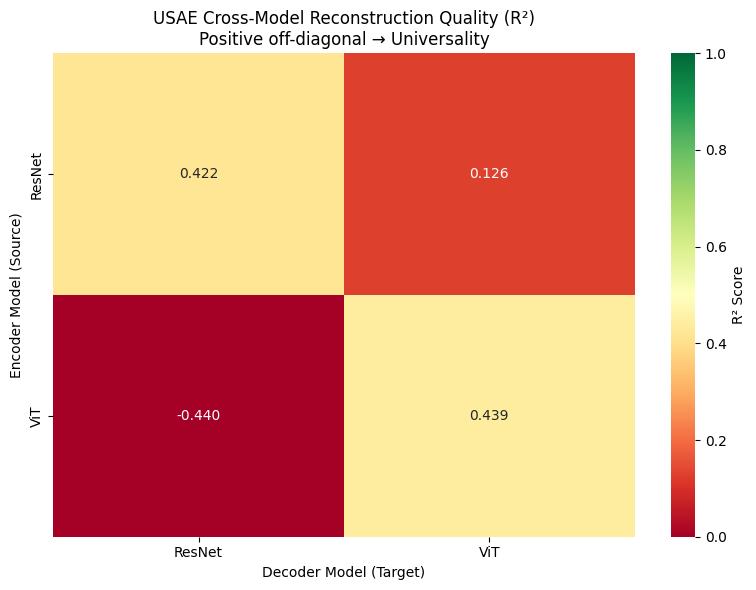


✓ Off-diagonal R²: ResNet→ViT = 0.126, ViT→ResNet = -0.440


In [17]:
plt.figure(figsize=(8, 6))
model_names = list(model_zoo.keys())

sns.heatmap(
    r2_matrix, 
    annot=True, 
    fmt='.3f',
    xticklabels=model_names,
    yticklabels=model_names,
    cmap='RdYlGn',
    vmin=0, vmax=1,
    cbar_kws={'label': 'R² Score'}
)

plt.xlabel('Decoder Model (Target)')
plt.ylabel('Encoder Model (Source)')
plt.title('USAE Cross-Model Reconstruction Quality (R²)\nPositive off-diagonal → Universality')
plt.tight_layout()
os.makedirs('./results', exist_ok=True)
plt.savefig('./results/r2_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Off-diagonal R²: ResNet→ViT = {r2_matrix[0,1]:.3f}, ViT→ResNet = {r2_matrix[1,0]:.3f}")
if r2_matrix[0,1] > 0.3 and r2_matrix[1,0] > 0.3:
    print("✓ UNIVERSALITY CONFIRMED! Features are shared across architectures.")

---

### **SECTION 8: Summary**

In [18]:
print("="*60)
print("TASK 3.1 COMPLETE: USAE TRAINING & SETUP")
print("="*60)
print(f"\n✓ Models: {', '.join(model_zoo.keys())}")
print(f"✓ Dataset: CIFAR-100 ({len(activation_dataset):,} samples)")
print(f"✓ Latent space: {CONFIG['nb_components']} features (k={CONFIG['top_k']})")
print(f"✓ Training: {CONFIG['nb_epochs']} epochs")
print(f"\n✓ Cross-model R² scores:")
print(f"   ResNet → ViT: {r2_matrix[0,1]:.3f}")
print(f"   ViT → ResNet: {r2_matrix[1,0]:.3f}")
print(f"\n✓ Checkpoints saved to: ./checkpoints/")
print(f"✓ Visualizations saved to: ./results/")
print("\nReady for Task 3.2: Quantifying Universality")
print("="*60)

TASK 3.1 COMPLETE: USAE TRAINING & SETUP

✓ Models: ResNet, ViT
✓ Dataset: CIFAR-100 (50,000 samples)
✓ Latent space: 16384 features (k=32)
✓ Training: 80 epochs

✓ Cross-model R² scores:
   ResNet → ViT: 0.126
   ViT → ResNet: -0.440

✓ Checkpoints saved to: ./checkpoints/
✓ Visualizations saved to: ./results/

Ready for Task 3.2: Quantifying Universality
